# Definitions, function utilities and constants

In [1]:
import struct #Used in load_cs8, using bb data type to read binaries
import numpy as np #Uses fft, and ffftshift
import matplotlib.pyplot as plt
import math
import cmath
import os
import subprocess
import sys
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def load_cs8(filename):
    "Load binary .cs8 file data in IQ vectors"
    I = []
    Q = []
    
    with open(filename, 'rb') as f:
        data = f.read()
    
   
    for i in range(0, len(data), 2):
        real_part, imag_part = struct.unpack('bb', data[i:i+2])
        I.append(real_part)
        Q.append(imag_part)
        
    return I, Q

def fft_scratch(x):
    """
    A custom, from-scratch implementation of the Cooley-Tukey FFT algorithm.
    It works for input arrays whose length is a power of 2.
    """
    N = len(x)
    if N <= 1:
        return x
    
    # Check if N is a power of 2
    if (N & (N - 1)) != 0:
        raise ValueError("FFT from scratch only works for signal lengths that are powers of 2.")

    even = fft_scratch(x[0::2])
    odd = fft_scratch(x[1::2])

    T = [0] * (N // 2)
    for k in range(N // 2):
        # Calculate twiddle factor
        twiddle = cmath.exp(-2j * cmath.pi * k / N)
        T[k] = twiddle * odd[k]
    
    X = [0] * N
    for k in range(N // 2):
        X[k] = even[k] + T[k]
        X[k + N // 2] = even[k] - T[k]
    
    return X

def generate_window(window_type, size, beta=None, alpha=None):
    """
    Generates a specified window function of a given size.

    Args:
        window_type (str): The type of window to generate.
                          Supported types: 'hamming', 'hann', 'rectangular',
                          'blackman', 'flat_top', 'kaiser', 'tukey', 'bartlett'.
        size (int): The size (length) of the window.
        beta (float, optional): The beta parameter for the Kaiser window. Defaults to None.
        alpha (float, optional): The alpha parameter for the Tukey window. Defaults to None.

    Returns:
        list: A list representing the generated window function.

    Raises:
        ValueError: If an unsupported window type is provided or required parameters are missing.
    """
    if size <= 0:
        raise ValueError("Window size must be a positive integer.")

    window = [0.0] * size

    if window_type == 'hamming':
        for n in range(size):
            window[n] = 0.54 - 0.46 * math.cos(2 * math.pi * n / (size - 1))
    elif window_type == 'hann':
        for n in range(size):
            window[n] = 0.5 * (1 - math.cos(2 * math.pi * n / (size - 1)))
    elif window_type == 'rectangular':
        window = [1.0] * size
    elif window_type == 'blackman':
        for n in range(size):
            window[n] = 0.42 - 0.5 * math.cos(2 * math.pi * n / (size - 1)) + 0.08 * math.cos(4 * math.pi * n / (size - 1))
    elif window_type == 'flat_top':
        a0, a1, a2, a3, a4 = 0.21557895, 0.41663158, 0.277263158, 0.083578947, 0.006947368
        for n in range(size):
            window[n] = a0 - a1 * math.cos(2 * math.pi * n / (size - 1)) + a2 * math.cos(4 * math.pi * n / (size - 1)) - a3 * math.cos(6 * math.pi * n / (size - 1)) + a4 * math.cos(8 * math.pi * n / (size - 1))
    elif window_type == 'kaiser':
        if beta is None:
            raise ValueError("Kaiser window requires a 'beta' parameter.")
        I_0_beta = I_0(beta)
        for n in range(size):
            arg = beta * math.sqrt(1 - (2.0 * n / (size - 1) - 1.0)**2)
            window[n] = I_0(arg) / I_0_beta
    elif window_type == 'tukey':
        if alpha is None or not 0 <= alpha <= 1:
            raise ValueError("Tukey window requires an 'alpha' parameter between 0 and 1.")
        half_alpha_N = alpha * (size - 1) / 2.0
        for n in range(size):
            if n < half_alpha_N:
                window[n] = 0.5 * (1 + math.cos(math.pi * (2 * n / (alpha * (size - 1)) - 1)))
            elif n > (size - 1) - half_alpha_N:
                window[n] = 0.5 * (1 + math.cos(math.pi * (2 * n / (alpha * (size - 1)) - 2 / alpha + 1)))
            else:
                window[n] = 1.0
    elif window_type == 'bartlett':
        for n in range(size):
            window[n] = 1 - abs(2 * n / (size - 1) - 1)
    else:
        raise ValueError(f"Unsupported window type: {window_type}")

    return window

def I_0(x):
    """
    Computes the modified zeroth-order Bessel function of the first kind.
    """
    sum_val = 1.0
    term = 1.0
    k = 1
    while term > 1e-9 * sum_val:
        term = term * (x * x / 4.0) / (k * k)
        sum_val += term
        k += 1
    return sum_val




#Path
current_dir = os.getcwd()
c_executable_path = os.path.join(current_dir, 'c-psd-estimator')
exchange_dir = os.path.join(current_dir, 'exchange')
test_sample = os.path.join(exchange_dir, "test_file.cs8")
c_output_path = os.path.join(exchange_dir, "psd_output_C.csv")

print(f"C-executable-path: {c_executable_path}")
print(f"Exchange-dir: {exchange_dir}")
print(f"Sample-file-path: {test_sample}")
print(f"C-output-path: {c_output_path}")


#Constants

FS = 20e6
NPERSEG = 4096
OVERLAP = 0.5
WINDOW = 'hamming'
CENT_FREQ = 98e6
BW = 20e6
INF_FREQ = CENT_FREQ - BW
SUP_FREQ = CENT_FREQ + BW

 
# Global signal

I, Q = load_cs8(test_sample)

signal = np.array(I) + 1j*np.array(Q)

C-executable-path: /home/javastral/GIT/GCPDS--trabajos-/welch-ane2/PSD-Estimation-final/c-psd-estimator
Exchange-dir: /home/javastral/GIT/GCPDS--trabajos-/welch-ane2/PSD-Estimation-final/exchange
Sample-file-path: /home/javastral/GIT/GCPDS--trabajos-/welch-ane2/PSD-Estimation-final/exchange/test_file.cs8
C-output-path: /home/javastral/GIT/GCPDS--trabajos-/welch-ane2/PSD-Estimation-final/exchange/psd_output_C.csv


## Welch's Method for Power Spectral Density Estimation

Welch's method is a technique for estimating the power spectral density of a signal. It's an improvement over the basic periodogram method as it reduces noise in the PSD estimate by averaging multiple modified periodograms.

---

### 1. Windowing Function

A **window function** is applied to each segment of the signal to reduce spectral leakage. Common window functions include Hamming, Hann, and Rectangular.
The code defines $w[n]$ based on the `window_type` parameter.

* **Hamming Window:**
    $$w[n] = 0.54 - 0.46 \cos\left(\frac{2\pi n}{M-1}\right), \quad 0 \le n \le M-1$$
* **Hann Window:**
    $$w[n] = 0.5 - 0.5 \cos\left(\frac{2\pi n}{M-1}\right), \quad 0 \le n \le M-1$$
* **Rectangular Window:**
    $$w[n] = 1, \quad 0 \le n \le M-1$$

Where $M$ is the `segment_length`.

---

### 2. Normalization Factor ($U$)

The **normalization factor** $U$ accounts for the power of the window function. It ensures that the PSD estimate has the correct units.

$$U = \sum_{n=0}^{M-1} w[n]^2$$

---

### 3. Segmenting the Signal

The input signal is divided into $K$ overlapping segments. The overlap percentage is defined by `overlap`.

* **Number of segments ($K$):**
    $$K = \left\lfloor \frac{N - M}{\text{step}} \right\rfloor + 1$$
    where $N$ is the total length of the signal, $M$ is the `segment_length`, and `step` is given by:
    $$\text{step} = M \times (1 - \text{overlap})$$

* **Individual Segment ($s_k[n]$):**
    Each segment $k$ is extracted and multiplied by the window function:
    $$s_k[n] = x[n + k \cdot \text{step}] \cdot w[n], \quad 0 \le n \le M-1$$
    where $x[n]$ is the original signal.

---

### 4. Discrete Fourier Transform (DFT) of Each Segment

For each windowed segment $s_k[n]$, its **Discrete Fourier Transform (DFT)** is computed. This is done using the Fast Fourier Transform (FFT) algorithm.

$$X_k[f] = \sum_{n=0}^{M-1} s_k[n] \cdot e^{-j 2\pi f n / M}$$

---

### 5. Periodogram of Each Segment ($P_k[f]$)

The **periodogram** for each segment is calculated from the magnitude squared of its DFT, normalized by the sampling frequency ($f_s$) and the window normalization factor ($U$).

$$P_k[f] = \frac{1}{f_s \cdot U} |X_k[f]|^2$$

---

### 6. Averaging the Periodograms

The final Welch PSD estimate is obtained by **averaging the periodograms** of all $K$ segments.

$$P_{\text{welch}}[f] = \frac{1}{K} \sum_{k=0}^{K-1} P_k[f]$$

---

### 7. Frequency Vector ($f$)

The corresponding **frequency values** for the PSD are generated using:

$$f = \text{FFTShift}\left(\text{frequencies for } \frac{1}{M \cdot \Delta t}\right)$$
where $\Delta t = 1/f_s$.

In [2]:
def welch_psd_scratch(signal, fs=1.0, segment_length=256, overlap=0.5, window_type='hamming', **kwargs):
    """
    Calculates the Welch Power Spectral Density (PSD) from scratch,
    using a custom FFT implementation and the generate_window function.
    
    The segment_length must be a power of 2 for the custom FFT to work.
    
    Args:
        signal (list): The input signal.
        fs (float): The sampling frequency.
        segment_length (int): The length of each segment. Must be a power of 2.
        overlap (float): The overlap between segments (0.0 to 1.0).
        window_type (str): The type of window to use.
        **kwargs: Extra keyword arguments for specific window types (e.g., beta for Kaiser).
    
    Returns:
        tuple: A tuple containing the frequency array and the PSD.
    """
    if (segment_length & (segment_length - 1)) != 0:
        raise ValueError("For this scratch implementation, segment_length must be a power of 2.")

    N = len(signal)
    step = int(segment_length * (1 - overlap))
    
    # Generate the window using the new function
    window = generate_window(window_type, segment_length, **kwargs)

    # Calculate normalization factor U
    U = sum(w ** 2 for w in window)

    # Number of segments
    K = (N - segment_length) // step + 1
    
    # Initialize the PSD accumulator
    P_welch = [0.0] * segment_length

    # Main loop over segments
    for k in range(K):
        start = k * step
        segment = signal[start:start + segment_length]
        
        # Apply window
        windowed_segment = [segment[i] * window[i] for i in range(segment_length)]
        
        # Calculate the FFT of the segment using the custom function
        X_k = fft_scratch(windowed_segment)
        
        # Calculate PSD for the segment
        P_k = [(1 / (fs * U)) * abs(x)**2 for x in X_k]
        
        # Add to the accumulator list
        for i in range(segment_length):
            P_welch[i] += P_k[i]

    # Average over segments
    P_welch = [p / K for p in P_welch]
    
    # Create the frequency array from scratch
    f = [0.0] * segment_length
    for i in range(segment_length):
        if i < segment_length / 2:
            f[i] = i * fs / segment_length
        else:
            f[i] = (i - segment_length) * fs / segment_length

    return f, P_welch


### Execute Welch's Method Python

In [3]:
f_scratch, Pxx_scratch = welch_psd_scratch(signal, fs=FS, segment_length=NPERSEG, overlap=OVERLAP, window_type=WINDOW)
f_scratch, Pxx_scratch = np.fft.fftshift(f_scratch), np.fft.fftshift(Pxx_scratch)

# Scratch Python vs C executable Scratch


--- PSD computation in C Done ---
Return Code: 0

--- Standard Output captured: ---
Successfully loaded 20000000 samples from /home/javastral/GIT/GCPDS--trabajos-/welch-ane2/PSD-Estimation-final/exchange/test_file.cs8
[welch] PSD computation complete.
PSD saved to /home/javastral/GIT/GCPDS--trabajos-/welch-ane2/PSD-Estimation-final/exchange/psd_output_C.csv

--- Standard Error captured: ---
No error output captured.


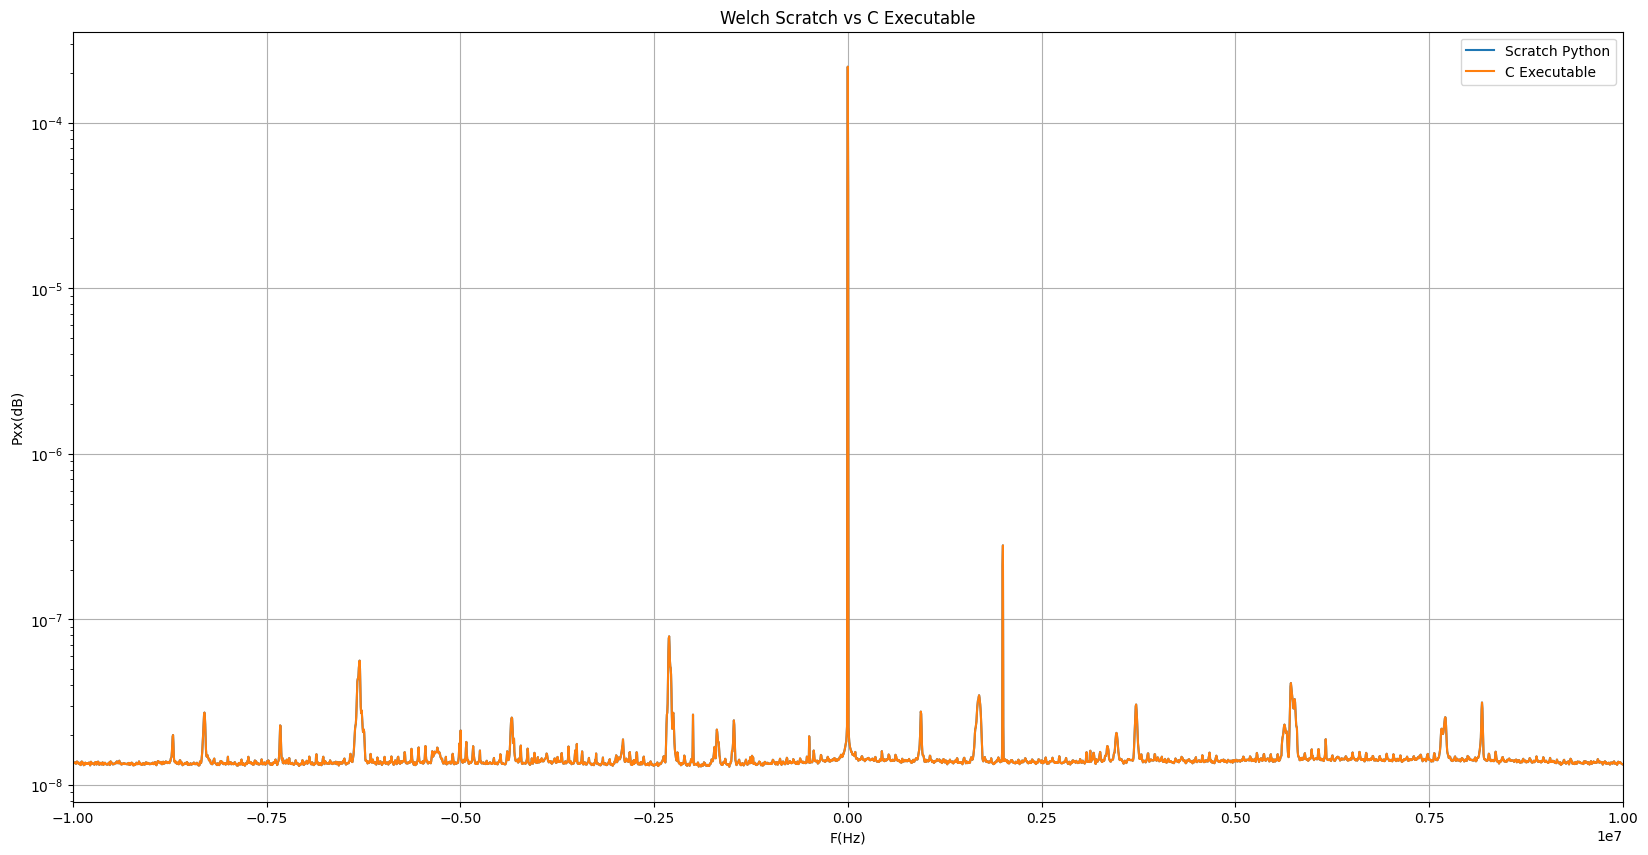

In [ ]:
try:

    result = subprocess.run(
        [c_executable_path, "welch"],
        check=True,
        capture_output=True,
        text=True
    )

    print("\n--- PSD computation in C Done ---")
    print(f"Return Code: {result.returncode}")

    print("\n--- Standard Output captured: ---")
    print(result.stdout)

    print("--- Standard Error captured: ---")
    if result.stderr:
        print(result.stderr)
    else:
        print("No error output captured.")

except FileNotFoundError:
    print(f"Executable not found: {c_executable_path}")
    sys.exit(1)
except subprocess.CalledProcessError as e:
    print(f"Error: C program failed with return code {e.returncode}.")
    print(f"--- Standard Error (stderr) of the failed program: ---\n{e.stderr}")
    sys.exit(1)

c_output = pd.read_csv(c_output_path)

f_c = np.array(c_output['Frequency_Hz'].values)
Pxx_c = np.array(c_output['PSD'].values)

plt.figure(figsize=(20, 10))
plt.semilogy(f_scratch, Pxx_scratch, label='Scratch Python')
plt.semilogy(f_c, Pxx_c, label='C Executable')
plt.title('Welch Scratch vs C Executable')
plt.xlabel('F(Hz)')
plt.ylabel('Pxx(dB)')
plt.grid(True)
plt.legend()
plt.xlim(-1e7,1e7)
plt.show()

# Metrics between Scratch Python and C Executable

In [5]:
# Frequencies
mse_f = mean_squared_error(f_scratch, f_c)
mae_f = mean_absolute_error(f_scratch, f_c)

print(f"\n--- Frequencies ---")

print(f"MSE: {mse_f:.40f}") 
print(f"MAE: {mae_f:.40f}")

# Power Spectral Density
mse_psd = mean_squared_error(Pxx_scratch, Pxx_c)
mae_psd = mean_absolute_error(Pxx_scratch, Pxx_c)

print(f"\n--- Power Spectral Density ---")

print(f"MSE: {mse_psd:.40f}")
print(f"MAE: {mae_psd:.40f}")


--- Frequencies ---
MSE: 0.0000001125487897039116560303240741416908
MAE: 0.0002250976178288510709535330533981323242

--- Power Spectral Density ---
MSE: 0.0000000000000000000000000000001564519645
MAE: 0.0000000000000000100352951114428933358077
